# Behavioural Cloning

This notebook trains a neural network to copy the behavior of the driver. 

## Loading the training Data

In [4]:
# import needed libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import cv2

In [5]:

def read_recording(csv_path="recording/driving_log.csv", collect_center=True, collect_right=False, 
               collect_left=False):
    # read the csv file
    data = pd.read_csv(csv_path,header = None)
    
    # initialize array of paths and images
    center_paths = []
    right_paths = []
    left_paths = []
    center_images = []
    right_images = []
    left_images = []
    steering = []
    # iterate throught data
    num_of_frames = data.shape[0]
    print("Reading {} Frames ...".format(num_of_frames))
    for i in range(0, num_of_frames):
        # extract the paths and read center images
        center_path = data[0][i]
        #print("center : ", center_path)
        center_paths.append(center_path)
        center_img = cv2.imread(center_path)
        #center_img = cv2.cvtColor(center_img, cv2.COLOR_BGR2RGB)
        center_images.append(center_img)
        # extract the paths and read right images
        right_path = data[2][i]
        right_paths.append(right_path)
        right_img = cv2.imread(right_path)
        #right_img = cv2.cvtColor(right_img, cv2.COLOR_BGR2RGB)
        right_images.append(right_img)
        # extract the paths and read left images
        left_path = data[1][i]
        left_paths.append(left_path)
        left_img = cv2.imread(left_path)
        #left_img = cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB)
        left_images.append(left_img)
        
        # extract the steering
        steering_angle = data[3][i]
        steering.append(steering_angle)
         
    print("Done Reading!")
    return center_images, right_images, left_images, steering

    

In [8]:
center_images, right_images, left_images, steering = read_recording()
images = center_images

Reading 1475 Frames ...
Done Reading!


## Preprocessing the data

In [20]:
def augment_data(center_images, steerings, right_images=None, left_images=None, correction= 0.5):
    augmented_images = []
    augmented_steering = []
    for image, steering in zip(center_images, steerings):
        augmented_images.append(image)
        augmented_images.append(cv2.flip(image, 1))
        augmented_steering.append(steering)
        augmented_steering.append(-1 * steering)
    if right_images and left_images:
        for right_image, left_image, steering in zip(right_images,left_images, steerings):
            augmented_images.append(right_image)
            augmented_steering.append(steering - correction)
            augmented_images.append(left_image)
            augmented_steering.append(steering + correction)

    return np.array(augmented_images), np.array(augmented_steering)
        

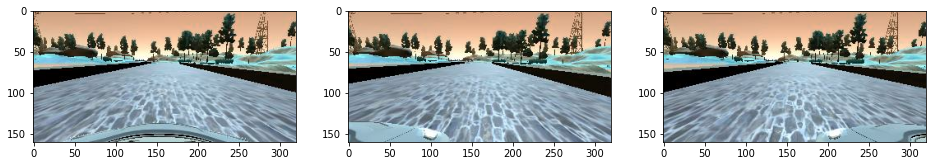

In [21]:
import random
import matplotlib.pyplot as plt

plt.figure(figsize=(16,12))
# plot sample image
img_index = random.randint(0, len(center_images)-1)
plt.subplot(1,3,1)
plt.imshow(center_images[img_index])
plt.subplot(1,3,2)
plt.imshow(right_images[img_index])
plt.subplot(1,3,3)
plt.imshow(left_images[img_index])
# downsample all images
# todo: data augmentation: flipping, etc.

In [22]:
# convert training data to numpy arrays:
# TODO: take in images from left and right camera
X_train, y_train = augment_data(center_images, steering, right_images, left_images)

In [23]:
X_train.shape

(5900, 160, 320, 3)

In [27]:
# quick and dirty model
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda
from keras.layers import Convolution2D, Cropping2D
from keras.layers.pooling import MaxPooling2D


## Workaround Keras not releasing the gpu problem
here the training is done in a subprocess

## NN Model

In [28]:
import multiprocessing

def train_model():
    model = Sequential()
    # crop top and bottom
    model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160,320,3)))
    model.add(Lambda(lambda x: x / 255 - 0.5))
    model.add(Convolution2D(6, 5,  activation='relu'))
    model.add(MaxPooling2D())
    model.add(Convolution2D(6, 5, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(120))
    model.add(Dense(84))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    model.fit(X_train, y_train, validation_split=0.2, shuffle=True, epochs=5)
    model.save('model.h5')
p = multiprocessing.Process(target=train_model)
p.start()
p.join()


Epoch 1/5
148/148 [==============================] - ETA: 0s - loss: 0.176 - ETA: 4s - loss: 12.12 - ETA: 5s - loss: 9.3254 - ETA: 5s - loss: 8.265 - ETA: 5s - loss: 6.739 - ETA: 5s - loss: 5.546 - ETA: 5s - loss: 4.712 - ETA: 5s - loss: 4.109 - ETA: 5s - loss: 3.651 - ETA: 5s - loss: 3.467 - ETA: 5s - loss: 3.298 - ETA: 5s - loss: 3.148 - ETA: 5s - loss: 2.880 - ETA: 5s - loss: 2.656 - ETA: 5s - loss: 2.466 - ETA: 5s - loss: 2.299 - ETA: 5s - loss: 2.224 - ETA: 5s - loss: 2.156 - ETA: 5s - loss: 2.089 - ETA: 5s - loss: 1.970 - ETA: 5s - loss: 1.866 - ETA: 5s - loss: 1.771 - ETA: 5s - loss: 1.685 - ETA: 5s - loss: 1.609 - ETA: 4s - loss: 1.572 - ETA: 4s - loss: 1.506 - ETA: 4s - loss: 1.474 - ETA: 4s - loss: 1.443 - ETA: 4s - loss: 1.414 - ETA: 4s - loss: 1.387 - ETA: 4s - loss: 1.361 - ETA: 4s - loss: 1.335 - ETA: 4s - loss: 1.310 - ETA: 4s - loss: 1.286 - ETA: 4s - loss: 1.264 - ETA: 4s - loss: 1.242 - ETA: 4s - loss: 1.221 - ETA: 4s - loss: 1.201 - ETA: 4s - loss: 1.181 - ETA: 4s - 

148/148 [==============================] - ETA: 0s - loss: 0.023 - ETA: 3s - loss: 0.026 - ETA: 5s - loss: 0.027 - ETA: 5s - loss: 0.028 - ETA: 6s - loss: 0.031 - ETA: 6s - loss: 0.030 - ETA: 6s - loss: 0.030 - ETA: 6s - loss: 0.031 - ETA: 6s - loss: 0.032 - ETA: 6s - loss: 0.031 - ETA: 6s - loss: 0.033 - ETA: 6s - loss: 0.032 - ETA: 6s - loss: 0.032 - ETA: 6s - loss: 0.033 - ETA: 6s - loss: 0.033 - ETA: 6s - loss: 0.033 - ETA: 6s - loss: 0.032 - ETA: 6s - loss: 0.031 - ETA: 6s - loss: 0.031 - ETA: 5s - loss: 0.031 - ETA: 5s - loss: 0.030 - ETA: 5s - loss: 0.030 - ETA: 5s - loss: 0.030 - ETA: 5s - loss: 0.030 - ETA: 5s - loss: 0.029 - ETA: 5s - loss: 0.029 - ETA: 5s - loss: 0.029 - ETA: 5s - loss: 0.029 - ETA: 5s - loss: 0.029 - ETA: 4s - loss: 0.029 - ETA: 4s - loss: 0.029 - ETA: 4s - loss: 0.029 - ETA: 4s - loss: 0.029 - ETA: 4s - loss: 0.029 - ETA: 4s - loss: 0.029 - ETA: 4s - loss: 0.029 - ETA: 4s - loss: 0.028 - ETA: 4s - loss: 0.028 - ETA: 4s - loss: 0.028 - ETA: 4s - loss: 0.028

148/148 [==============================] - ETA: 0s - loss: 0.019 - ETA: 4s - loss: 0.015 - ETA: 5s - loss: 0.018 - ETA: 5s - loss: 0.018 - ETA: 5s - loss: 0.017 - ETA: 5s - loss: 0.018 - ETA: 5s - loss: 0.018 - ETA: 5s - loss: 0.018 - ETA: 5s - loss: 0.018 - ETA: 5s - loss: 0.018 - ETA: 5s - loss: 0.018 - ETA: 5s - loss: 0.017 - ETA: 5s - loss: 0.017 - ETA: 5s - loss: 0.017 - ETA: 5s - loss: 0.017 - ETA: 5s - loss: 0.017 - ETA: 5s - loss: 0.017 - ETA: 5s - loss: 0.017 - ETA: 5s - loss: 0.017 - ETA: 5s - loss: 0.017 - ETA: 5s - loss: 0.016 - ETA: 5s - loss: 0.016 - ETA: 5s - loss: 0.016 - ETA: 5s - loss: 0.016 - ETA: 5s - loss: 0.016 - ETA: 5s - loss: 0.016 - ETA: 5s - loss: 0.016 - ETA: 5s - loss: 0.016 - ETA: 5s - loss: 0.016 - ETA: 5s - loss: 0.016 - ETA: 5s - loss: 0.016 - ETA: 5s - loss: 0.016 - ETA: 5s - loss: 0.016 - ETA: 5s - loss: 0.016 - ETA: 5s - loss: 0.016 - ETA: 5s - loss: 0.016 - ETA: 5s - loss: 0.016 - ETA: 5s - loss: 0.016 - ETA: 5s - loss: 0.016 - ETA: 4s - loss: 0.016

## Training the Network

## Visualizing the Accuracy